# Generating random surfaces - filter method
Often in tribology we will want to generate random surfaces with particular properties, we can use these ase roughness in simulations to investigate how our contact changes with specific roughness parameters. Slippy contains several methods for making randomly rough surfaces. These are:

- RandomFilterSurface
- RandomPerezSurface
- HurstFractalSurface

These methods vary in terms of performance and flexibility: 

Filtering of random sequences, as provided by RandomFilterSurface allows the user to specify the autocorrelation function of the surface profile and gives some flexability over the distribution of surface heights. 

The Perez method allows the powerspectral density and the height function to be set. The method will give a surface that perfectly matches one of these specifications and matches the other to a settable tollerance. 

Hurst fractals allow control over the frequeny components present in the surface. The amplitude of each component is define by a simple function in the frequency domain. This gives no control over the height distribution.

---
In this notebook we will run through an example of generating a random rough surface by the filter method.

Lets start by importing everything we will need, and setting the random seed so we always get the same sequence of random numbers. This just ensures that the surfaces generated will be the same every time this is run.

In [1]:
import slippy.surface as S  # surface generation and manipulation
import numpy as np          # numerical functions
np.random.seed(0)
%matplotlib inline


# RandomFilterSurface

The RandomFilterSurface provides surface realisations based on linear transformations (or filtering) of random sequences. This method works by finding a filter which can be used on un corelated gausian random numbers, to give a sequence with the desired autocorelation function. This process typically involves three steps:

- Solve the inverse problem to find the filter coefficients
- Find the skew and kurtosis of the input sequence needed to give the desired skew and kurtosis in the generated profile
- Generate a random sequence and filter it.

Practically, almost all of the computational time is used in the first step. Because of this, in slippy, these steps are separated so users can generate multiple 'realisations' of similar random surfaces without having to repetedly solve the inverse problem for the filter coefficients. 

In order to fit a random surface we need an autocorelation function to use as a target. Slippy provides an ACF object to make auto corelation functions that are independent of grid spacing. Here we will generate an ACF with the formula:

$ACF(x',y') = \sigma^2 exp\left(-2.3\left(\left(\frac{x'}{\beta_x}\right)^2+\left(\frac{y'}{\beta_y}\right)^2\right)^{0.5}\right)$

In this example $\sigma = 2,\ \beta_x = 0.1,\ \beta_y = 0.2$

For user defined autocorelation functions the ACF constructor also takes arrays which it can interopolate over or callable functions which give the value of the acf at each point.

In [2]:
target_acf = S.ACF('exp', 2, 0.1, 0.2)

## Finding the filter coefficients
We can now solve the inverse problem by making an instance of RandomFilterSurface, setting method to linear transforms will use the method defined in:

Dongri Liao, Wen Shao, Jinyuan Tang, Jianping Li,
An improved rough surface modeling method based on linear transformation technique,
Tribology International,
Volume 119,
2018,
Pages 786-794,
ISSN 0301-679X,
https://doi.org/10.1016/j.triboint.2017.12.008.
(http://www.sciencedirect.com/science/article/pii/S0301679X17305662)

We can also use a symmetric filter to ensure the resulting ACF is symmetric as suggested in:

Michael Watson, Roger Lewis, Tom Slatter,
Improvements to the linear transform technique for generating randomly rough surfaces with symmetrical autocorrelation functions,
Tribology International,
Volume 151,
2020,
106487,
ISSN 0301-679X,
https://doi.org/10.1016/j.triboint.2020.106487.
(http://www.sciencedirect.com/science/article/pii/S0301679X20303091)

This process is accelerated by fft convolution to generate the acf estimate and by just in time compilation of the gradient function. Any optimisation method avaliable as part of scipy's minimize function can be used.

At this point we need to specify the size of the filter that we want to fit and the grid spacing of the final surface, the solutiuon for the filter coefficients matrix is unique for both of these parameters.

Practically, using a larger filter will give more accurate results, however the solution will take longer to converge. You will likely need to experiment and see what works for your particular situation. Broarder ACFs will also require a larger filter.

In [3]:
lin_trans_surface = S.RandomFilterSurface(target_acf=target_acf, grid_spacing=0.01)
lin_trans_surface.linear_transform(filter_shape=(40,20), gtol=1e-5, symmetric=True)

## Generating surface realisations
Generating surface profiles can now be done extremely quickly. Below we will generate a new periodic realisation and show it's profile, ACF and a histogram of it's heights.

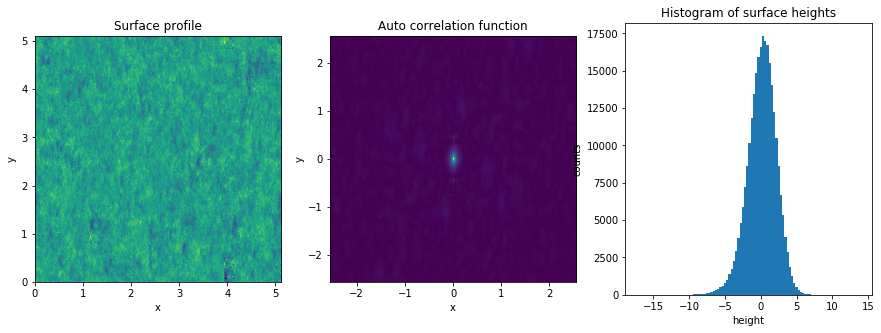

In [10]:
my_realisation = lin_trans_surface.discretise([512,512], periodic=True, create_new=True)
fig, axes = my_realisation.show(['profile', 'acf', 'histogram'], ['image', 'image'], figsize=(15,5))

In [5]:
my_realisation.roughness(['Sq', 'Ssk', 'Sku'])

[2.01178040697847, -0.009151639233851145, 2.9448218573261475]

we can demostrate that the generated profile is periodic by shifting the profile and replotting:

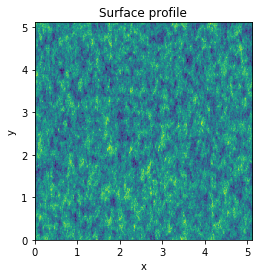

In [6]:
S.Surface(profile=np.fft.fftshift(my_realisation.profile), grid_spacing=my_realisation.grid_spacing).show()

We can also investigate how closely our generated surfae matches the target acf:

Text(0.5, 1.0, 'Comparison along x direction')

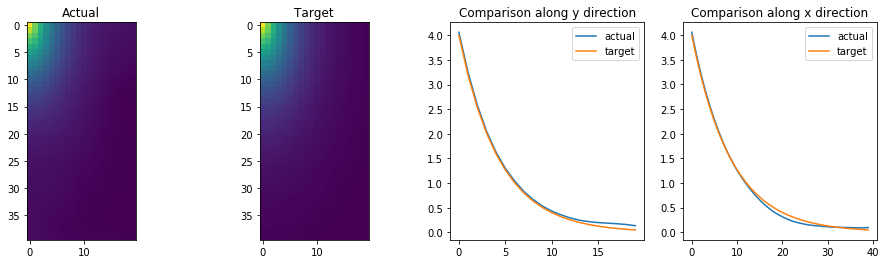

In [7]:
import matplotlib.pyplot as plt
target = lin_trans_surface.target_acf_array
actual = np.array(my_realisation.acf)
n,m = actual.shape
tn,tm = target.shape
actual_comparible = actual[n//2:n//2+tn,m//2:m//2+tm]
fig,axes = plt.subplots(1,4, figsize=(16,4))
axes[0].imshow(actual_comparible); axes[0].set_title('Actual')
axes[1].imshow(target); axes[1].set_title('Target')
axes[2].plot(actual_comparible[0,:], label='actual')
axes[2].plot(target[0,:], label='target')
axes[2].legend(); axes[2].set_title('Comparison along y direction')
axes[3].plot(actual_comparible[:,0], label='actual')
axes[3].plot(target[:,0], label='target')
axes[3].legend(); axes[3].set_title('Comparison along x direction')

## Notes:
Often surface generated by the filter method will contain unwanted high frequency components giving them a 'printed on fabric' appearance. These can be removed by specifying a symmetric filter or increasing the filter size. Both of these increase the time required to fit the filter, however, the filter only needs to be fitted once no matter how many realisations are required, for the same acf and grid spacing. If either the ACF or grid spacing changes a new filter will need to be fitted.

# Generating non normally distributed surfaces
We can see from the histogram of surface heights (on the right above) that the surface heights ae approximately normally distributed. This will be generally true of a surface made by filtering a normally distributed sequence. Using the method defined in the reference below, we can alter the distribution of the sequence before filtering. This allows us to specify a target skew and kurtosis of the surface ehight distribution. In slippy we have followed the method given here:

Manesh, K. K., Ramamoorthy, B., & Singaperumal, M. (2010). Numerical generation of anisotropic 3D non-Gaussian engineering surfaces with specified 3D surface roughness parameters. Wear, 268(11–12), 1371–1379. https://doi.org/10.1016/j.wear.2010.02.005

Below we will set the skew and kutosis and generate another realisation. Note that this method has a limited applicability as the input sequence must be fittable by a johnson distribution.

C:\Users\mea08\code\SlipPY\slippy\surface\Surface_class.py:962: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


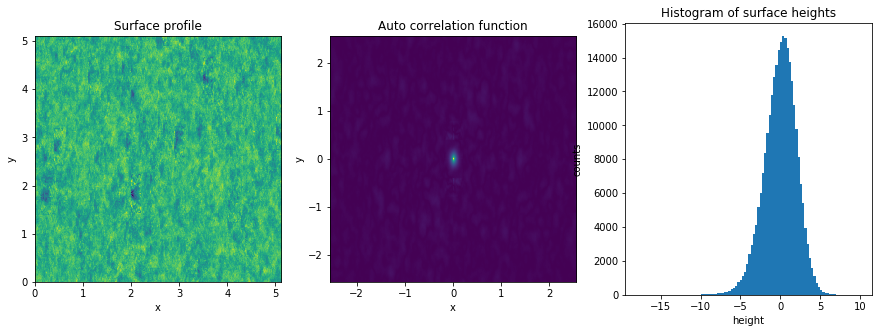

In [8]:
lin_trans_surface.set_moments(skew = -0.5, kurtosis=5)
my_realisation = lin_trans_surface.discretise([512,512], periodic=False, create_new=True)
fig, axes = my_realisation.show(['profile', 'acf', 'histogram'], ['image', 'image'], figsize=(15,5))

In [9]:
my_realisation.roughness(['Sq', 'Ssk', 'Sku'])

[2.0358245782244855, -0.4865889446944429, 4.12909972829951]

As shown we have generated a randomly rough surface with the specified height distribution and autocorrelation function. Please note that, even for quite large samples (of any set of random numbers), the 3rd and 4th moments (the skew and kurtosis) can be quite different to those of the population, so we cannot expect our surface to match the target distribution exactly.